# Модуль 4. Разработка математического аппарата

## 0 Предисловие

### 0.1 Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import cv2

In [ ]:
from PIL import Image

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

In [ ]:
from scipy.io import wavfile

In [ ]:
import pickle as pkl

In [ ]:
import scipy.signal as signal

In [ ]:
RANDOM_STATE=666

### 0.2 Загрузка результатов модуля C

In [ ]:
%%time
try:
    with open('..\\C1_M3\\exp_df.data', 'rb') as f:
        exp_df = pkl.load(f)
except Exception as e:
    print(e)

CPU times: total: 0 ns
Wall time: 978 µs


In [ ]:
exp_df.sample(5)

,48130,32773,72709,71689,3081,25610,36877,42000,52240,21527,...,5095,12265,27627,49134,53238,62459,21500,temp,cluster,mode
2166,179,234,117,27,19,19,242,237,146,147,...,157,39,244,35,162,34,15,74.222222,1,3
2069,83,181,122,65,58,57,222,120,34,91,...,159,60,233,72,55,70,54,49.433333,1,2
5,24,35,134,181,152,144,39,40,24,87,...,157,152,51,206,17,207,130,26.543816,2,1
584,22,35,134,184,157,147,40,43,25,91,...,160,158,52,214,14,213,136,31.046619,2,1
2171,181,234,117,27,18,16,246,242,153,153,...,155,42,246,34,162,33,14,75.500000,1,3


# 1 Подготовка финальной выборки для обучения

Перед разделением выборки на train, test, valid необходимо добавить новые признаки и проанализировать их

## 1.1 Генерация новых переменных на основе имеющихся

Новый признак "время в секундах" для каждого эксперимента

In [ ]:
# длины экспериментов
len_list = [284, 281, 282, 274, 284, 280, 288, 280, 291]

In [ ]:
times = []

for l in len_list:
    times += list(range(l))

In [ ]:
exp_df['time'] = pd.Series(times)

In [ ]:
exp_df

,48130,32773,72709,71689,3081,25610,36877,42000,52240,21527,...,12265,27627,49134,53238,62459,21500,temp,cluster,mode,time
0,25,37,136,187,155,148,40,42,25,89,...,158,54,214,19,215,136,25.300000,2,1,0
1,23,37,136,185,157,149,40,41,24,90,...,159,54,214,17,214,136,25.548763,2,1,1
2,22,35,135,182,156,145,40,42,24,89,...,157,52,212,18,214,135,25.797527,2,1,2
3,22,35,133,179,152,142,40,42,24,88,...,155,52,208,17,211,133,26.046290,2,1,3
4,25,35,136,185,153,149,39,40,24,89,...,158,53,215,18,215,135,26.295053,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,199,223,119,14,9,9,250,241,193,170,...,56,244,19,189,19,9,95.309655,1,3,286
2540,199,226,119,13,9,9,249,241,194,170,...,56,244,20,191,19,8,95.557241,1,3,287
2541,201,227,119,13,9,8,248,241,196,174,...,56,245,20,192,19,10,95.804828,1,3,288
2542,202,227,119,12,9,9,248,241,198,175,...,56,245,20,193,19,9,96.052414,1,3,289


Добавим признак "количество энергии", как Ватт/с

In [ ]:
exp_df['p']= exp_df['p'].apply(np.abs)

In [ ]:
exp_df['watt_s'] = exp_df['time'] * exp_df['p']

Новый признак "окончание эксперимента"

In [ ]:
end_arr = np.zeros(exp_df.shape[0])

In [ ]:
for ind in len_list:
    end_arr[ind - 1] = 1

In [ ]:
exp_df['end'] = end_arr

## 1.2 Анализ сгенерированных переменных

Корреляционный анализ

In [ ]:
col_is_not_pixel = []
for col in exp_df.columns:
    try:
        num = int(col)
    except:
        col_is_not_pixel.append(col)

In [ ]:
print(col_is_not_pixel)

['t', 'w', 'a', 'p', 'ws', 'herz', 'co2', 'vl', 'v', 'temp', 'cluster', 'mode', 'time', 'watt_s', 'end']


In [ ]:
exp_corr = exp_df[col_is_not_pixel].corr()

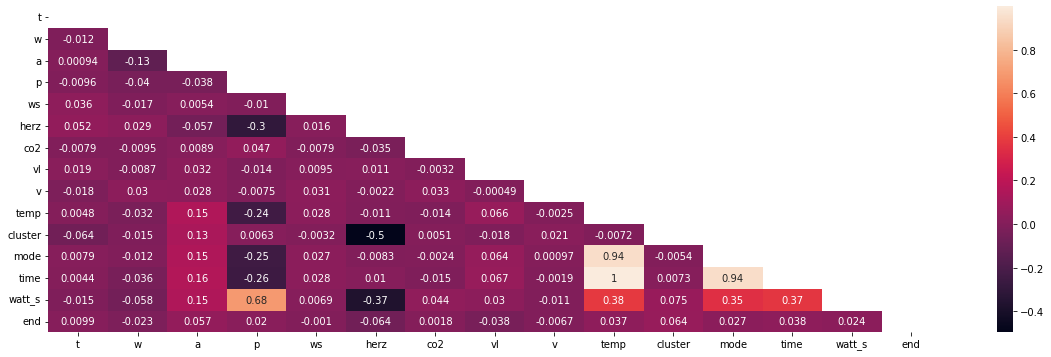

In [ ]:
plt.figure(figsize=(20,6))
sns.heatmap(exp_corr, mask=np.triu(exp_corr), annot=True);

Наблюдается очень сильная корреляция между **режимом** и **временем испытания**. Поскольку переменные с очень сильной корреляцией предоставляют идентичную информацию модели, то удалим "режим", поскольку нигде в задании он не фигурирует.

In [ ]:
exp_df = exp_df.drop('mode', axis=1)

Поскольку напряжение я удалил в прошлом модуле, а в данном модуле оно вновь понадобилось, то вернём его на место

In [ ]:
%%time
try:
    with open('..\\C1_M2\\exp_df.data', 'rb') as f:
        exp_df_mod2 = pkl.load(f)
except Exception as e:
    print(e)

CPU times: total: 62.5 ms
Wall time: 55.9 ms


In [ ]:
exp_df['volt'] = exp_df_mod2['volt']

In [ ]:
# del exp_df_mod2

## 1.3 Разбиение выборки на тренировочную, выборочную и валидационную выборки

Для заданий из пп. 2, 4 осуществим разбиение по всей выборке в долях train-70%, test-20%, valid-10%. 

In [ ]:
# валидационная выборка
valid_df = exp_df.sample(frac=0.1, random_state=RANDOM_STATE)

In [ ]:
# получаем индексы объектов, не попавших в valid выборку
all_indices = set(range(exp_df.shape[0]))
free_indices = all_indices.difference(set(valid_df.index.tolist()))

In [ ]:
# 20% из оставшихся значений выделяем под test
test_df = exp_df.loc[free_indices].sample(frac=0.2, random_state=RANDOM_STATE)

In [ ]:
# оставшееся, не попавшее в valid и test уходит под train
for_train_indices = free_indices.difference(set(test_df.index.tolist()))
train_df = exp_df.loc[for_train_indices]

In [ ]:
exp_df.shape

(2544, 498)

In [ ]:
valid_df.shape[0] + test_df.shape[0] + train_df.shape[0]

2544

Так сделано, чтобы каждый раз не вызывать train_test_split, выделяя target.

Для предсказания момента отключения (под задачу п.3) возьмём полностью один эксперимент, как valid, два эксперимента под test и 6 экспериментов, как train. Это будет сделано для того, чтобы в выборках гарантированно присутствовал момент отключения.

Временно вернём номера экспериментов

In [ ]:
exp_df['num_experiment'] = exp_df_mod2['num_experiment']

In [ ]:
valid_df_for3 = exp_df.query('num_experiment == 9')

In [ ]:
test_df_for3 = exp_df.query('num_experiment in [7, 8]')

In [ ]:
train_df_for3 = exp_df.query('num_experiment < 7')

In [ ]:
exp_df.drop('num_experiment', axis=1, inplace=True)

## 2 Выбор и настройка параметров модели регрессии для прогнозирования температуры

Отделяем объекты-цель

In [ ]:
y_train = train_df['temp']
y_test = test_df['temp']
y_valid = valid_df['temp']

In [ ]:
# для модели по акустическим данным
X_train_acoustic = pd.DataFrame(train_df['w'])
X_test_acoustic = pd.DataFrame(test_df['w'])
X_valid_acoustic = pd.DataFrame(valid_df['w'])

# для модели по данным тока и напряжения
X_train_a_volt = train_df[['a', 'volt']]
X_test_a_volt = test_df[['a', 'volt']]
X_valid_a_volt = valid_df[['a', 'volt']]

# для модели по акустическим данным, данным тока и напряжения
X_train_a_volt_acoustic = train_df[['w', 'a', 'volt']]
X_test_a_volt_acoustic = test_df[['w', 'a', 'volt']]
X_valid_a_volt_acoustic = valid_df[['w', 'a', 'volt']]

Обучать будем 3 модели градиентного бустинга

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

### 2.1 Модель по акустическим данным

In [ ]:
gbc_acoustic = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_acoustic.fit(X_train_acoustic, y_train);

### 2.2 Модель по данным тока и напряжения

In [ ]:
gbc_a_volt = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_a_volt.fit(X_train_a_volt, y_train);

### 2.3 Модель по данным тока, напряжения и акустике

In [ ]:
gbc_a_volt_acoustic = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_a_volt_acoustic.fit(X_train_a_volt_acoustic, y_train);

### 2.4 Cравнение моделей и оценка точности

Сравнение будем осуществлять с помощью метрик $R^2$ и MAPE

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

Модель по акустическим данным

In [ ]:
r2_score(y_test, gbc_acoustic.predict(X_test_acoustic))

0.20930415669271585

In [ ]:
mean_absolute_percentage_error(y_test, gbc_acoustic.predict(X_test_acoustic))

0.28556935124583815

Модель по данным тока и напряжения

In [ ]:
r2_score(y_test, gbc_a_volt.predict(X_test_a_volt))

0.2091865130592031

In [ ]:
mean_absolute_percentage_error(y_test, gbc_a_volt.predict(X_test_a_volt))

0.2983153211647596

Модель по данным тока, напряжения и акустике

In [ ]:
r2_score(y_test, gbc_a_volt_acoustic.predict(X_test_a_volt_acoustic))

0.4123160465879261

In [ ]:
mean_absolute_percentage_error(y_test, gbc_a_volt_acoustic.predict(X_test_a_volt_acoustic))

0.2290639304165503

Наилучшие результаты показала **модель, построенная на данных по току, напряжению и акустике**, т.к. коэффициент детерминации ($R^2$) (оценка точности для задач регрессии) выше, а абсолютная процентная ошибка (MAPE) ниже - ~23% ошибок

### 2.5 Анализ параметров модели

С помощью подбора гиперпараметров и кросс-валидации найдём лучшие параметры для модели

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'learning_rate': np.linspace(0.1, 1, 5),
    'n_estimators': [50, 100, 150, 200],
    'subsample': np.linspace(0.1, 1, 5),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 4),
    'max_depth': range(2, 6),
    'random_state': [RANDOM_STATE]
}

In [ ]:
gscv = GridSearchCV(GradientBoostingRegressor(), param_grid=params, cv=5, n_jobs=-1, scoring='r2', verbose=1)

In [ ]:
%%time
gscv.fit(X_train_a_volt_acoustic, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
CPU times: total: 23.6 s
Wall time: 3min 22s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'max_depth': range(2, 6),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 5),
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [666],
                         'subsample': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring='r2', verbose=1)

Наилучшие параметры для модели:

In [ ]:
best_params = gscv.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50,
 'random_state': 666,
 'subsample': 1.0}

### 2.6 Обучение и тестирование выбранной модели

In [ ]:
best_model = GradientBoostingRegressor(**best_params)

Обучаем на выборке train + test

In [ ]:
X_train_test = exp_df[['w', 'a', 'volt']].loc[free_indices]
y_train_test = exp_df.loc[free_indices]['temp']

In [ ]:
%%time
best_model.fit(X_train_test, y_train_test)

CPU times: total: 46.9 ms
Wall time: 48.9 ms


GradientBoostingRegressor(max_depth=2, min_samples_leaf=2, n_estimators=50,
                          random_state=666)

Тестировать будем на валидационной выборке

In [ ]:
r2_score(y_valid, best_model.predict(X_valid_a_volt_acoustic))

0.34835306160312596

In [ ]:
mean_absolute_percentage_error(y_valid, best_model.predict(X_valid_a_volt_acoustic))

0.26409071483407626

Построим кривую обучения

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
train_sizes_abs, train_scores, test_scores = learning_curve(
    best_model,
    exp_df[['w', 'a', 'volt']], 
    exp_df['temp'], 
    random_state=RANDOM_STATE, 
    n_jobs=-1, 
    cv=5, 
    scoring='r2'
)

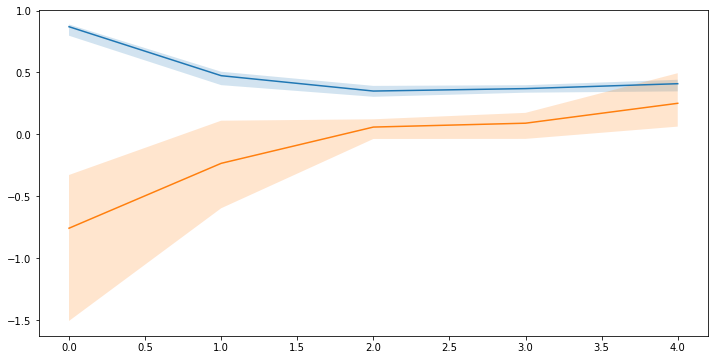

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(train_scores, axis=1))
plt.plot(np.mean(test_scores, axis=1))
plt.fill_between(np.linspace(0, 4, 5), np.min(train_scores, axis=1), np.max(train_scores, axis=1), alpha=0.2)
plt.fill_between(np.linspace(0, 4, 5), np.min(test_scores, axis=1), np.max(test_scores, axis=1), alpha=0.2);

На этом графике мы видим, что модель недообучена. Хорошей тактикой было бы добавление новых данных, но таковых не предоставлено.

### 2.7 Сохранение лучшей модели

In [ ]:
%%time
try:
    with open('model_for_temp.data', 'wb') as f:
        pkl.dump(best_model, f)
except Exception as e:
    print(e)

CPU times: total: 0 ns
Wall time: 2 ms


## 3 Выбор и настройка параметров модели регрессии для прогнозирования момента времени отключения установки

Отделяем объекты-цель

In [ ]:
y_train = train_df_for3['time']
y_test = test_df_for3['time']
y_valid = valid_df_for3['time']

In [ ]:
# для модели по акустическим данным
X_train_acoustic = train_df_for3[['w', 'end']]
X_test_acoustic = test_df_for3[['w', 'end']]
X_valid_acoustic = valid_df_for3[['w', 'end']]

# для модели по данным тока и напряжения
X_train_a_volt = train_df_for3[['a', 'volt', 'end']]
X_test_a_volt = test_df_for3[['a', 'volt', 'end']]
X_valid_a_volt = valid_df_for3[['a', 'volt', 'end']]

# для модели по акустическим данным, данным тока и напряжения
X_train_a_volt_acoustic = train_df_for3[['w', 'a', 'volt', 'end']]
X_test_a_volt_acoustic = test_df_for3[['w', 'a', 'volt', 'end']]
X_valid_a_volt_acoustic = valid_df_for3[['w', 'a', 'volt', 'end']]

Обучать будем 3 модели градиентного бустинга

### 3.1 Модель по акустическим данным

In [ ]:
gbc_acoustic = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_acoustic.fit(X_train_acoustic, y_train);

### 3.2 Модель по данным тока и напряжения

In [ ]:
gbc_a_volt = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_a_volt.fit(X_train_a_volt, y_train);

### 3.3 Модель по данным тока, напряжения и акустике

In [ ]:
gbc_a_volt_acoustic = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_a_volt_acoustic.fit(X_train_a_volt_acoustic, y_train);

### 3.4 Cравнение моделей и оценка точности

Сравнение будем осуществлять с помощью метрик $R^2$ и MAPE

Модель по акустическим данным

In [ ]:
r2_score(y_test, gbc_acoustic.predict(X_test_acoustic))

0.11832212231351125

In [ ]:
mean_absolute_percentage_error(y_test, gbc_acoustic.predict(X_test_acoustic))

2523023989975839.0

Модель по данным тока и напряжения

In [ ]:
r2_score(y_test, gbc_a_volt.predict(X_test_a_volt))

-0.044326568696187785

In [ ]:
mean_absolute_percentage_error(y_test, gbc_a_volt.predict(X_test_a_volt))

2297773935650128.0

Модель по данным тока, напряжения и акустике

In [ ]:
r2_score(y_test, gbc_a_volt_acoustic.predict(X_test_a_volt_acoustic))

0.04481649619366235

In [ ]:
mean_absolute_percentage_error(y_test, gbc_a_volt_acoustic.predict(X_test_a_volt_acoustic))

2613752488161757.0

Остановимся на модели с аудио данными, т.к. $R^2$ в этом случае выше

### 3.5 Анализ параметров модели

С помощью подбора гиперпараметров и кросс-валидации найдём лучшие параметры для модели

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'learning_rate': np.linspace(0.1, 1, 5),
    'n_estimators': [50, 100, 150, 200],
    'subsample': np.linspace(0.1, 1, 5),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 4),
    'max_depth': range(2, 6),
    'random_state': [RANDOM_STATE]
}

In [ ]:
gscv = GridSearchCV(GradientBoostingRegressor(), param_grid=params, cv=5, n_jobs=-1, scoring='r2', verbose=1)

In [ ]:
%%time
gscv.fit(X_train_acoustic, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
CPU times: total: 16.6 s
Wall time: 2min 11s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'max_depth': range(2, 6),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 5),
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [666],
                         'subsample': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring='r2', verbose=1)

Наилучшие параметры для модели:

In [ ]:
best_params = gscv.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50,
 'random_state': 666,
 'subsample': 1.0}

### 3.6 Обучение и тестирование выбранной модели

In [ ]:
best_model = GradientBoostingRegressor(**best_params)

Обучаем на выборке train + test

In [ ]:
X_train_test = exp_df[['w', 'end']].loc[free_indices]
y_train_test = exp_df.loc[free_indices]['time']

In [ ]:
%%time
best_model.fit(X_train_test, y_train_test)

CPU times: total: 31.2 ms
Wall time: 27 ms


GradientBoostingRegressor(max_depth=2, min_samples_leaf=2, n_estimators=50,
                          random_state=666)

Тестировать будем на валидационной выборке

In [ ]:
r2_score(y_valid, best_model.predict(X_valid_acoustic))

0.27987731005440697

In [ ]:
mean_absolute_percentage_error(y_valid, best_model.predict(X_valid_acoustic))

1376554476600279.2

Построим кривую обучения

In [ ]:
train_sizes_abs, train_scores, test_scores = learning_curve(
    best_model,
    exp_df[['w', 'end']], 
    exp_df['time'], 
    random_state=RANDOM_STATE, 
    n_jobs=-1, 
    cv=5, 
    scoring='r2'
)

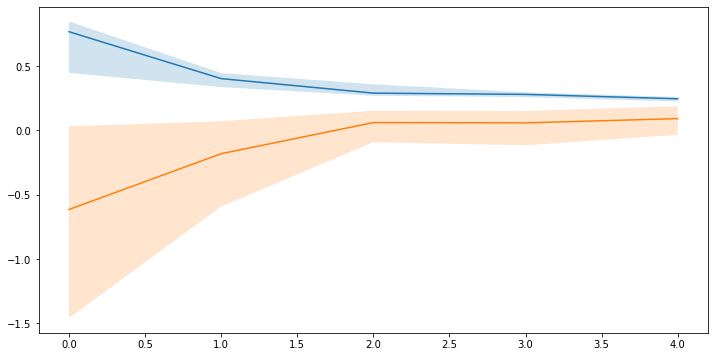

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(train_scores, axis=1))
plt.plot(np.mean(test_scores, axis=1))
plt.fill_between(np.linspace(0, 4, 5), np.min(train_scores, axis=1), np.max(train_scores, axis=1), alpha=0.2)
plt.fill_between(np.linspace(0, 4, 5), np.min(test_scores, axis=1), np.max(test_scores, axis=1), alpha=0.2);

На этом графике мы видим, что модель недообучена. Хорошей тактикой было бы добавление новых данных.

### 3.7 Сохранение лучшей модели

In [ ]:
%%time
try:
    with open('model_for_time.data', 'wb') as f:
        pkl.dump(best_model, f)
except Exception as e:
    print(e)

CPU times: total: 0 ns
Wall time: 2 ms


## 4 Выбор и настройка параметров модели регрессии для прогнозирования количества энергии, которое тратится на нагревание теплоносителя

Отделяем объекты-цель

In [ ]:
y_train = train_df['watt_s']
y_test = test_df['watt_s']
y_valid = valid_df['watt_s']

In [ ]:
# для модели по акустическим данным
X_train_acoustic = pd.DataFrame(train_df['w'])
X_test_acoustic = pd.DataFrame(test_df['w'])
X_valid_acoustic = pd.DataFrame(valid_df['w'])

# для модели по данным тока и напряжения
X_train_a_volt = train_df[['a', 'volt']]
X_test_a_volt = test_df[['a', 'volt']]
X_valid_a_volt = valid_df[['a', 'volt']]

# для модели по акустическим данным, данным тока и напряжения
X_train_a_volt_acoustic = train_df[['w', 'a', 'volt']]
X_test_a_volt_acoustic = test_df[['w', 'a', 'volt']]
X_valid_a_volt_acoustic = valid_df[['w', 'a', 'volt']]

Обучать будем 3 модели градиентного бустинга

### 4.1 Модель по акустическим данным

In [ ]:
gbc_acoustic = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_acoustic.fit(X_train_acoustic, y_train);

### 4.2 Модель по данным тока и напряжения

In [ ]:
gbc_a_volt = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_a_volt.fit(X_train_a_volt, y_train);

### 4.3 Модель по данным тока, напряжения и акустике

In [ ]:
gbc_a_volt_acoustic = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
gbc_a_volt_acoustic.fit(X_train_a_volt_acoustic, y_train);

### 4.4 Cравнение моделей и оценка точности

Сравнение будем осуществлять с помощью метрик $R^2$ и MAPE

Модель по акустическим данным

In [ ]:
r2_score(y_test, gbc_acoustic.predict(X_test_acoustic))

0.047481751211171486

In [ ]:
mean_absolute_percentage_error(y_test, gbc_acoustic.predict(X_test_acoustic))

1.7111665381541514e+17

Модель по данным тока и напряжения

In [ ]:
r2_score(y_test, gbc_a_volt.predict(X_test_a_volt))

0.5496626653939688

In [ ]:
mean_absolute_percentage_error(y_test, gbc_a_volt.predict(X_test_a_volt))

1.265807148118703e+17

Модель по данным тока, напряжения и акустике

In [ ]:
r2_score(y_test, gbc_a_volt_acoustic.predict(X_test_a_volt_acoustic))

0.6687758790914566

In [ ]:
mean_absolute_percentage_error(y_test, gbc_a_volt_acoustic.predict(X_test_a_volt_acoustic))

9.150022899245882e+16

Наилучшие результаты показала **модель, построенная на данных по току, напряжению и акустике**, т.к. коэффициент детерминации ($R^2$) (оценка точности для задач регрессии) выше, а абсолютная процентная ошибка (MAPE) ниже

### 4.5 Анализ параметров модели

С помощью подбора гиперпараметров и кросс-валидации найдём лучшие параметры для модели

In [ ]:
params = {
    'learning_rate': np.linspace(0.1, 1, 5),
    'n_estimators': [50, 100, 150, 200],
    'subsample': np.linspace(0.1, 1, 5),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 4),
    'max_depth': range(2, 6),
    'random_state': [RANDOM_STATE]
}

In [ ]:
gscv = GridSearchCV(GradientBoostingRegressor(), param_grid=params, cv=5, n_jobs=-1, scoring='r2', verbose=1)

In [ ]:
%%time
gscv.fit(X_train_a_volt_acoustic, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
CPU times: total: 23.2 s
Wall time: 3min 24s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'max_depth': range(2, 6),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 5),
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [666],
                         'subsample': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring='r2', verbose=1)

Наилучшие параметры для модели:

In [ ]:
best_params = gscv.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 666,
 'subsample': 1.0}

### 4.6 Обучение и тестирование выбранной модели

In [ ]:
best_model = GradientBoostingRegressor(**best_params)

Обучаем на выборке train + test

In [ ]:
X_train_test = exp_df[['w', 'a', 'volt']].loc[free_indices]
y_train_test = exp_df.loc[free_indices]['watt_s']

In [ ]:
%%time
best_model.fit(X_train_test, y_train_test)

CPU times: total: 125 ms
Wall time: 136 ms


GradientBoostingRegressor(min_samples_leaf=2, random_state=666)

Тестировать будем на валидационной выборке

In [ ]:
r2_score(y_valid, best_model.predict(X_valid_a_volt_acoustic))

0.7077113747535904

In [ ]:
mean_absolute_percentage_error(y_valid, best_model.predict(X_valid_a_volt_acoustic))

4.0075803923898374e+17

Построим кривую обучения

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
train_sizes_abs, train_scores, test_scores = learning_curve(
    best_model,
    exp_df[['w', 'a', 'volt']], 
    exp_df['watt_s'], 
    random_state=RANDOM_STATE, 
    n_jobs=-1, 
    cv=5, 
    scoring='r2'
)

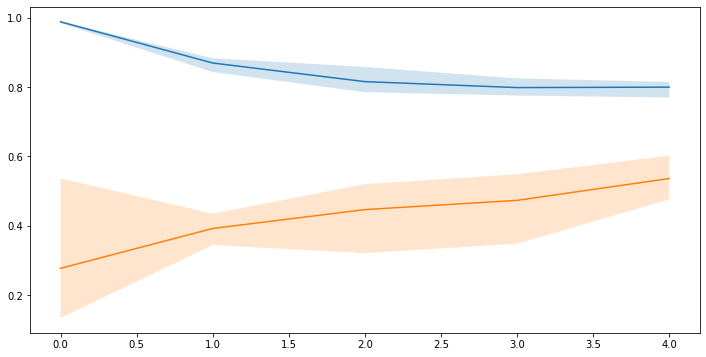

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(train_scores, axis=1))
plt.plot(np.mean(test_scores, axis=1))
plt.fill_between(np.linspace(0, 4, 5), np.min(train_scores, axis=1), np.max(train_scores, axis=1), alpha=0.2)
plt.fill_between(np.linspace(0, 4, 5), np.min(test_scores, axis=1), np.max(test_scores, axis=1), alpha=0.2);

На этом графике мы видим, что модель недообучена. Хорошей тактикой было бы добавление новых данных, но таковых не предоставлено.

### 4.7 Сохранение лучшей модели

In [ ]:
%%time
try:
    with open('model_for_watt_s.data', 'wb') as f:
        pkl.dump(best_model, f)
except Exception as e:
    print(e)

CPU times: total: 0 ns
Wall time: 2.99 ms


## 5 Итоги

В ходе проделанной работы было разработано 9 моделей регрессии для прогнозирования с некоторой вероятностью температуры, момента времени отключения установки, количества энергии, которое тратится на нагревание теплоносителя на основе данных по данным тока, напряжения и акустике. 3 модели были отобраны по лучшим метрикам, подобраны наилучшие гиперпараметры для них, после чего 3 модели были обучены с отобранными гиперпараметрами. Проведено тестирование новых моделей, после чего они сохранены.

Все 3 модели, судя по всему, недообучены, поэтому либо нужно добавлять больше данных, либо пытаться создать модель на всех имеющихся признаках (а не только 3).